In [22]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

## 1. Lectura de datos

In [23]:
url = 'https://l2h237eh53.execute-api.us-east-1.amazonaws.com/dev/precios'

def obtener_datos_api():
    try:
        respuesta = requests.get(url+'?start_date=2024-03-15&end_date=2024-04-14')
        return respuesta.json()
    except requests.exceptions.HTTPError as e:
        print(e)
        return None
    
datos = obtener_datos_api()

#### ¿Cuántos días de datos se obtienen?

In [6]:
print('Se obtienen',len(datos["data"]), 'días')

Se obtienen 30 días


## 2. Procesamiento de los datos

In [6]:
df = pd.json_normalize(datos['data'])
df = df.transpose()
df = df.reset_index()
df = df.rename(columns={'index': 'fecha_aux'})

In [ ]:
df['fecha_aux'] = df['fecha_aux'].str.replace(".", " ")
df['fecha_aux'] = df['fecha_aux'].str.replace("24:00", "00:00")

df['fecha_aux'] = pd.to_datetime(df['fecha_aux'])
df.columns = ['Fecha','Precio']

## 3. Tratamiento de datos faltantes

#### Para rellenar horas faltantes

In [8]:
#Horas sin Precio
horas_faltantes = df[df['Precio'].isna()]
horas_faltantes

,Fecha,Precio
566,2024-04-08 15:00:00,None
590,2024-04-09 15:00:00,None
591,2024-04-09 16:00:00,None
592,2024-04-09 17:00:00,None


In [9]:
# Se llenan las horas faltantes con el valor anterior más cercano
df['Precio'] = df['Precio'].ffill()

#### Para rellenar los días faltantes

In [10]:
# Se identifican las fechas faltantes
fechas = pd.date_range(start='2024-03-15', end='2024-04-14', freq='H')
fechas_faltantes = fechas.difference(df['Fecha'])
fechas_faltantes

DatetimeIndex(['2024-03-18 00:00:00', '2024-03-18 01:00:00',
               '2024-03-18 02:00:00', '2024-03-18 03:00:00',
               '2024-03-18 04:00:00', '2024-03-18 05:00:00',
               '2024-03-18 06:00:00', '2024-03-18 07:00:00',
               '2024-03-18 08:00:00', '2024-03-18 09:00:00',
               '2024-03-18 10:00:00', '2024-03-18 11:00:00',
               '2024-03-18 12:00:00', '2024-03-18 13:00:00',
               '2024-03-18 14:00:00', '2024-03-18 15:00:00',
               '2024-03-18 16:00:00', '2024-03-18 17:00:00',
               '2024-03-18 18:00:00', '2024-03-18 19:00:00',
               '2024-03-18 20:00:00', '2024-03-18 21:00:00',
               '2024-03-18 22:00:00', '2024-03-18 23:00:00'],
              dtype='datetime64[ns]', freq=None)

In [11]:
# Con las fechas faltantes creo un DF y lo concateno con el original
df_faltantes = pd.DataFrame({'Fecha': fechas_faltantes, 'Precio' : None})

df_completo = pd.concat([df, df_faltantes], ignore_index=True)
df_completo = df_completo.sort_values(by='Fecha').reset_index(drop=True)

C:\Users\Erika\AppData\Local\Temp\ipykernel_21472\1864773236.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_completo = pd.concat([df, df_faltantes], ignore_index=True)


In [12]:
#Se agrupa por día y se calcula el promedio diario
df_promedio_diario = df_completo.groupby(df_completo['Fecha'].dt.date)['Precio'].mean().reset_index()
df_promedio_diario.columns = ['fecha_aux', 'promedio_diario']

In [13]:
#Con el promedio diario, se calculan los promedios teniendo en cuenta los días anteriores y posteriores.
df_promedio_copy = df_promedio_diario
df_promedio_copy['promedio_diario'] = df_promedio_copy['promedio_diario'].rolling(window=6, min_periods=1, center=True).mean()

In [ ]:
df_completo['fecha_aux'] = df_completo['Fecha'].dt.date

# Teniendo la columna fecha_aux (día) en el df_completo se hace un merge con el promedio diario para luego rellenar los NaN con la columna promedio_diario (promedio móvil de 7 días)
df_completo = df_completo.merge(df_promedio_copy, on='fecha_aux', how='left')

# Rellenar los valores faltantes en df_completo con el promedio diario
df_completo['Precio'] = df_completo['Precio'].fillna(df_completo['promedio_diario'])
df_completo.drop(columns=['fecha_aux', 'promedio_diario'], inplace=True)
df_completo

,Fecha,Precio
0,2024-03-15 00:00:00,551.70
1,2024-03-15 01:00:00,551.70
2,2024-03-15 02:00:00,551.70
3,2024-03-15 03:00:00,551.70
4,2024-03-15 04:00:00,497.36
...,...,...
739,2024-04-14 19:00:00,1056.17
740,2024-04-14 20:00:00,1056.17
741,2024-04-14 21:00:00,1056.17
742,2024-04-14 22:00:00,1056.17


## 4. Cálculo de promedios

In [15]:
#Se agrupa por día y se calcula el promedio diario
df_promedio_diario['promedio_movil_7d'] = df_promedio_diario['promedio_diario'].rolling(window=7, min_periods=1).mean()
df_promedio_diario

,fecha_aux,promedio_diario,promedio_movil_7d
0,2024-03-15,571.161111,571.161111
1,2024-03-16,571.161111,571.161111
2,2024-03-17,582.721250,575.014491
3,2024-03-18,591.309333,579.088201
4,2024-03-19,610.609167,585.392394
5,2024-03-20,637.143417,594.017565
6,2024-03-21,663.900667,604.000865
7,2024-03-22,661.878472,616.960488
8,2024-03-23,681.582083,632.734913
9,2024-03-24,716.694931,651.874010


## 5. Visualización de resultados

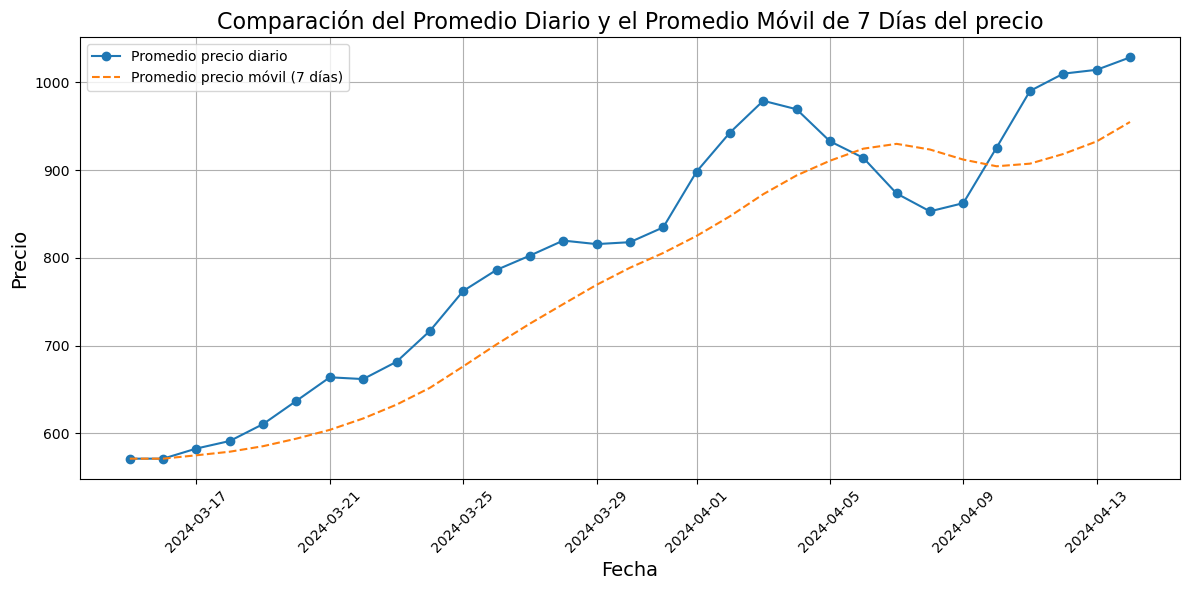

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_promedio_diario['fecha_aux'], df_promedio_diario['promedio_diario'], label='Promedio precio diario', marker='o')
plt.plot(df_promedio_diario['fecha_aux'], df_promedio_diario['promedio_movil_7d'], label='Promedio precio móvil (7 días)', linestyle='--')

plt.title('Comparación del Promedio Diario y el Promedio Móvil de 7 Días del precio', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio', fontsize=14)
plt.legend(loc='upper left')
plt.grid()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('image.png')
plt.show()

## 6. Almacenamiento de resultados

In [ ]:
conn = sqlite3.connect('precios.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS precios_diarios (
    fecha TEXT PRIMARY KEY,
    precio_promedio REAL,
    precio_7d REAL
)
''')
conn.commit()

In [ ]:
cursor.executemany('''
INSERT INTO precios_diarios (fecha, precio_promedio, precio_7d)
VALUES (?, ?, ?)
''', df_promedio_diario.values.tolist())

conn.commit()

In [35]:
conn.close()